In [ ]:
import tensorflow as tf
import numpy as np
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt

##Importing Dataset from GitHub

In [ ]:
!git clone https://github.com/darkwebber/rain_detection.git

Cloning into 'rain_detection'...
remote: Enumerating objects: 15029, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 15029 (delta 3), reused 10 (delta 1), pack-reused 15013
Receiving objects: 100% (15029/15029), 853.78 MiB | 33.13 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (15003/15003), done.


In [ ]:
import os
import shutil
import glob
import random

to_be_moved = random.sample(glob.glob("/content/rain_detection/rainy_image_dataset/rainy_image_dataset/abundant_class/rainy_image/*.jpg"), 900)

for f in enumerate(to_be_moved, 1):
    print()
    dest = os.path.join("/content/rain_detection/rainy_image_dataset/rainy_image_dataset/training/rainy_image","")
    if not os.path.exists(dest):
        os.makedirs(dest)
    shutil.copy(f[1], dest)

##Loading Image Data

In [ ]:
train_dir = pathlib.Path("/content/rain_detection/rainy_image_dataset/rainy_image_dataset/training")
val_dir = pathlib.Path("/content/rain_detection/rainy_image_dataset/rainy_image_dataset/testing")

In [ ]:
len([y for y in [x for x in train_dir.iterdir() if x.is_dir()][1].iterdir()])

1728

In [ ]:
img_height = 384
img_width = 384
batch_size = 32

In [ ]:
train_ds =tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed = 456,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2628 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed = 456,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 1500 files belonging to 2 classes.


##Visualising the Data

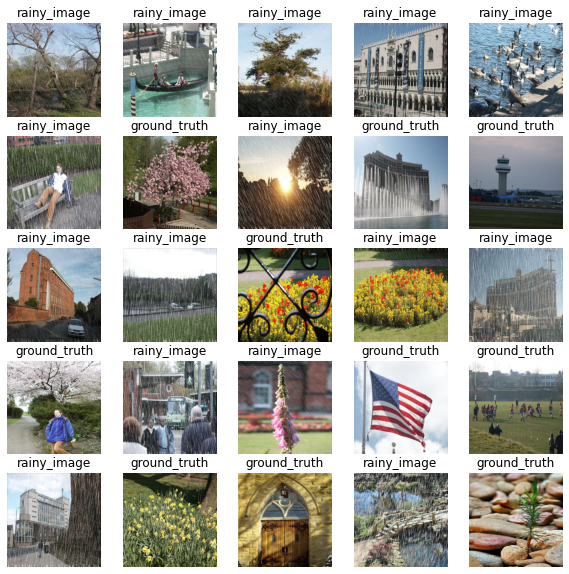

In [ ]:
plt.figure(figsize=(10, 10))
for imgs, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(imgs[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

##Building Neural Network

In [ ]:
norm_layer = tf.keras.layers.Rescaling(1./255,input_shape=(img_width, img_height, 3)) #to normalize rgb values

In [ ]:

model = tf.keras.Sequential([
  norm_layer,
  tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(
  optimizer='adam',
  loss = 'binary_crossentropy',
  metrics=['binary_accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True,
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data =val_ds,
    epochs = 30,
    callbacks = [early_stopping]
)

Epoch 1/30
83/83 [==============================] - 28s 205ms/step - loss: 0.4963 - binary_accuracy: 0.7607 - val_loss: 0.1895 - val_binary_accuracy: 0.9327
Epoch 2/30
82/83 [============================>.] - ETA: 0s - loss: 0.3450 - binary_accuracy: 0.8681

##Training Visualisation

In [ ]:
import pandas as pd

Minimum validation loss: 0.09571675956249237


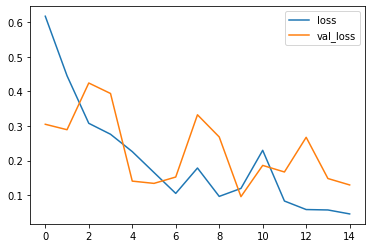

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

##Model Evaluation

In [ ]:
predictions = model.predict(val_ds)

47/47 [==============================] - 5s 99ms/step


In [ ]:
pred = predictions>=0.5
sh= pred.shape
pred = np.array([int(x) for x in pred]).reshape(sh)
y = np.concatenate([y for x,y in val_ds],axis = 0)

In [ ]:
tf.math.confusion_matrix(
    y,
    pred,
    num_classes = 2,
    dtype = tf.dtypes.int64
)

<tf.Tensor: shape=(2, 2), dtype=int64, numpy=
array([[   0,  100],
       [  75, 1325]])>

##Single Image Classification

In [ ]:
#os.mkdir("/content/rain_detection/external_testing_images/rainy/")
#os.mkdir("/content/rain_detection/external_testing_images/not_rainy/")

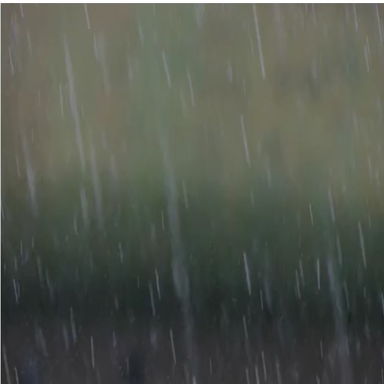

In [ ]:
im = PIL.Image.open(r"/content/rain_detection/external_testing_images/rainy/8.jpg")
res_im = im.resize((img_width, img_height))
res_im

In [ ]:
imge = np.array(res_im)
imge = np.expand_dims(imge, axis=0)

In [ ]:
pred = model.predict((imge))
print(pred)
if pred>= 0.5:
  print("rainy")
else:
  print("not rainy")

1/1 [==============================] - 0s 16ms/step
[[0.05464168]]
not rainy


##Detection of Rain in Video

####Identification of rain in a frame

In [ ]:
def identify(image,image_width,image_height):
  image = cv.resize(image, (image_width,image_height))
  res_image = np.array(image)
  res_image = np.expand_dims(res_image, axis=0)
  prediction = model.predict((res_image),verbose=0)
  #print(prediction)
  if prediction>= 0.5:
    #print("rainy")
    return True
  else:
    #print("not rainy")
    return False 

####TimeStamping start and end points of rain

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow

In [ ]:
capture = cv.VideoCapture("/content/rain_detection/external_testing_images/Nee Varum Pothu Video Song Mazhai Tamil  (You2Audio.Com).mp4")
check_point = False
while True:
  isTrue, frame = capture.read()
  if not isTrue:
    print("ended")
    break
  isRain = identify(frame,img_width,img_height)
  if isRain and not check_point:
    check_point = True
    print("Started")
    cv2_imshow(frame)
  elif not isRain and check_point:
    check_point = False
    print("Stopped") 
    cv2_imshow(frame)
  if cv.waitKey(20) & 0xFF == ord('d'):
    break
capture.release()
cv.destroyAllWindows()

KeyboardInterrupt: ignored